# Continuous Control

### 1. Start the Environment

We begin by importing the necessary packages. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
from collections import namedtuple, deque
%matplotlib inline

Next, we will start the environment, where a double-jointed arm can move to target locations. For each time step, a reward of `+0.1` is given when the agent's hand is in the goal location. The objective of the agent, therefore, is to maintain its position at the target location for as many time steps as possible. 

In [2]:
env = UnityEnvironment(file_name="D:\Programs\projects\deep-reinforcement-learning\Policy-based-methods\p2_continuous-control\Reacher_Windows_x86_64\Reacher_Windows_x86_64\Reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


**_Brains_** are responsible for deciding the actions of their associated agents in the environment. We can set the first brain available as the default brain that controls the arm.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Some information about the environment can be obtained by running the code below.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])


Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Code Cells

#### Parameters

In [5]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay for Adam Optimizer
UPDATE_INTERVAL = 20    # Number of episodes elapsed between updates
UPDATE_FREQUENCY = 3    # Number of times parameters and policy will be updated from a sample of experiences in each update
UPDATE_STEP = 0         # Step counter for update (update begins when it hits 0 again after UPDATE_INTERVAL steps)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Agent

In [6]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.update_step = UPDATE_STEP

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        # the following line is added so update interval can be adjusted
        self.update_step = (self.update_step + 1) % UPDATE_INTERVAL
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            if self.update_step == 0:
                #update multiple times after certain number of steps
                for i in range(UPDATE_FREQUENCY):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True, gaussian=False):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            if not gaussian:
                action += self.noise.sample()
            else:
                action += np.random.normal()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    

#### Model

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x) 

### 4. Main Program

In [8]:
agent = Agent(state_size, action_size, random_seed=10)
def ddpg(n_episodes=600, max_t=2000, print_every=20):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0                      # initialize the score 
        agent.reset()
        for t in range(max_t):
            action = agent.act(state, True, True)            # add noise?(Bool), Gaussian?(Bool)
            env_info = env.step(action)[brain_name]          # send all actions to tne environment
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)> max_score:
            max_score = np.mean(scores_deque)
        #solution found if average score over 100 episode is at least 30
        if np.mean(scores_deque) >= 30.0 and i_episode >= 100: 
            print ('\rProblem solved in Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            return scores
    print ('\rProblem not solved in Episode {}\tMax Average Score: {:.2f}'.format(n_episodes, max_score))
    return scores

scores = ddpg()


D:\Programs\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
D:\Programs\envs\drlnd\lib\site-packages\ipykernel_launcher.py:90: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 20	Average Score: 0.68
Episode 40	Average Score: 1.04
Episode 60	Average Score: 1.49
Episode 80	Average Score: 1.84
Episode 100	Average Score: 2.55
Episode 120	Average Score: 4.33
Episode 140	Average Score: 8.06
Episode 160	Average Score: 12.67
Episode 180	Average Score: 17.87
Episode 200	Average Score: 23.07
Episode 220	Average Score: 27.91
Problem solved in Episode 235	Average Score: 30.11


In [9]:
### 5. Result and Visual Presentation

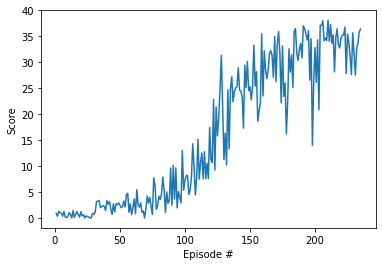

D:\Programs\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
for t in range(200):
    action = agent.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]          # send all actions to tne environment
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    state = next_state
    if done:
        break 


When finished, you can close the environment.

In [11]:
env.close()

In [12]:
#agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
#agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [13]:
print (scores[-100:])

[27.22999939136207, 22.399999499320984, 24.329999456182122, 25.05999943986535, 25.269999435171485, 28.949999352917075, 24.609999449923635, 24.46999945305288, 23.299999479204416, 17.319999612867832, 29.43999934196472, 25.119999438524246, 30.149999326094985, 24.539999451488256, 25.259999435395002, 22.759999491274357, 25.419999431818724, 33.31999925523996, 25.389999432489276, 28.1899993699044, 18.639999583363533, 20.659999538213015, 22.06999950669706, 35.459999207407236, 23.499999474734068, 32.16999928094447, 28.519999362528324, 26.849999399855733, 28.50999936275184, 31.779999289661646, 32.239999279379845, 31.299999300390482, 27.10999939404428, 34.989999217912555, 26.269999412819743, 33.559999249875546, 35.92999919690192, 31.649999292567372, 22.179999504238367, 33.129999259486794, 23.42999947629869, 26.01999941840768, 16.179999638348818, 22.57999949529767, 32.57999927178025, 28.10999937169254, 31.439999297261238, 25.12999943830073, 35.9399991966784, 36.48999918438494, 31.619999293237925, 

### 6. Discussion

It uses a Deep Deterministic Policy Gradient (DDPG) approach, which involves an actor network and a critic network. 

The “Critic” estimates the value function. This could be the action-value (the Q value) or state-value (the V value). The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients). Both the Critic and Actor functions are parameterized with neural networks. 

There are three other important features. 

1.) Replay buffer - At each timestep the actor and critic are updated by sampling a minibatch uniformly from the buffer. Because DDPG is an off-policy algorithm, the replay buffer can be large, allowing the algorithm to benefit from learning across a set of uncorrelated transitions.

2.) Soft update - For both actor and critic, their target network weights are mixed with a small fraction of the regular network weights during each update. This can create faster convergence.

3.) Noise - A small amount of noise is added to each action in each time step. This can help with exploration. I found that Gaussian noise works much better than Ornstein-Uhlenbeck noise.

Since update interval and frequency were mentioned in the benchmark implementation, I experimented those as well as the batch size, which is the number of replay examples used in each update. The current configuration seems to generate the best results. Basically, I want to do a number of updates each time after a certain number of episodes. 

Both actor and critic neural networks consist of multiple linear layers. Their structures mirror those in the Bipedal and Pendulum examples in the class's Github repository. 

For future improvement, I will try adding noise to the parameters as well, which can lead to more consistent exploration and a richer set of behaviors (arXiv:1706.01905 [cs.LG]). I will also try priority experience replay: replaying important    transitions more frequently can help agent learn more efficiently (arXiv:1511.05952v4 [cs.LG]). 